In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
import pickle

print(tf.__version__)

2024-12-10 20:53:26.873109: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 20:53:26.880013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 20:53:26.888095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 20:53:26.890567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 20:53:26.896506: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpuid = 0 #int(args.gpu_id)                                                                                                                           
if gpus:
  # Restrict TensorFlow to only allocate X GB of memory on the first GPU                                                                              
  try:
    tf.config.set_visible_devices(gpus[gpuid], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpuid], True)
    '''
    tf.config.set_logical_device_configuration(
        gpus[gpuid],
        [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
    '''
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized                                                                                   
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1733889209.987338   85636 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733889210.011413   85636 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733889210.013361   85636 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733889210.016655   85636 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    inputs = np.load("all_inputs_down_samp.npy")

In [4]:
inputs.shape

(3470, 512, 512, 1)

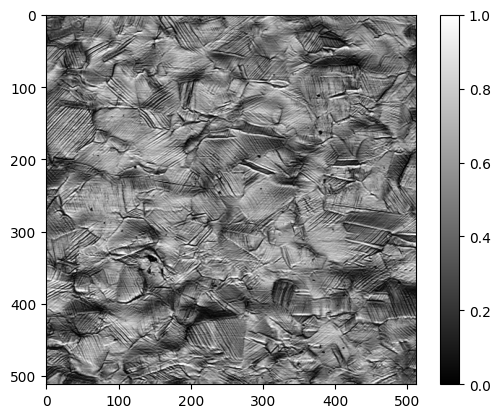

In [5]:
plt.imshow(inputs[0],cmap='grey')
plt.colorbar()

In [4]:
batchsize = 32

with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    targets = np.load("all_targets_down_samp.npy")
    # train test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(inputs, targets, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

with tf.device("/CPU:0") :
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
with tf.device("/GPU:0") :
    train_dataset = train_dataset.shuffle(buffer_size=200).batch(batchsize)
    val_dataset = val_dataset.shuffle(buffer_size=200).batch(batchsize)

In [6]:
inputs.shape

(3470, 512, 512, 1)

In [7]:
conv_dim = 16
ff_dim = 32
k_dim = 3
pool_dim = 5
drop_rate = 0.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), activation='relu', input_shape=(512, 512, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(ff_dim, activation='relu'),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

/home/user/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 510, 510, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 510, 510, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 102, 102, 16)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 102, 102, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 20, 20, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 18, 18, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 3, 3, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,665 (37.75 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 96 (384.00 B)

In [8]:
#model.compile(optimizer=Adam(learning_rate=1e-4),
#model.compile(optimizer=Adam(learning_rate=1e-2),
#model.compile(optimizer=Adam(learning_rate=1e-5),
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [9]:
model_checkpoint = ModelCheckpoint(
  filepath='checkpoint.model41.keras',
  monitor='val_loss',
  mode='min',
  save_best_only=True)

optim = model.fit(train_dataset,
                  validation_data=val_dataset, 
                  epochs=100, 
                  callbacks=[model_checkpoint])

Epoch 1/100


I0000 00:00:1733887356.638996   69358 service.cc:146] XLA service 0x72033c105820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733887356.639018   69358 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-12-10 20:22:36.660883: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 20:22:36.789414: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-10 20:22:38.907915: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng57{k2=0,k13=2,k14=2,k18=1,k23=0} for conv (f32[16,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,512,512]{3,2,1,0}, f32[32,16,510,510]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0"

10/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5582 - loss: 0.6967

I0000 00:00:1733887360.582915   69358 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6017 - loss: 0.6648 - val_accuracy: 0.4586 - val_loss: 0.7992
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7574 - loss: 0.4994 - val_accuracy: 0.4586 - val_loss: 1.5135
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8071 - loss: 0.4151 - val_accuracy: 0.4586 - val_loss: 1.5124
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8294 - loss: 0.3765 - val_accuracy: 0.4586 - val_loss: 0.9496
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8421 - loss: 0.3313 - val_accuracy: 0.5414 - val_loss: 1.5635
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8761 - loss: 0.2876 - val_accuracy: 0.4586 - val_loss: 3.7778
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8980 - loss: 0.2544 - val_accuracy: 0.4694 - val_loss: 2.3356
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9127 - loss: 0.2194 - val_accuracy: 0.6691 - val_

In [10]:
optim.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

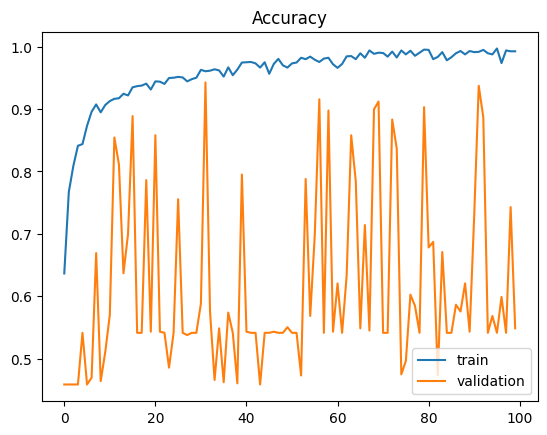

In [10]:
plt.plot(optim.history['accuracy'])
plt.plot(optim.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('Accuracy')
plt.show()

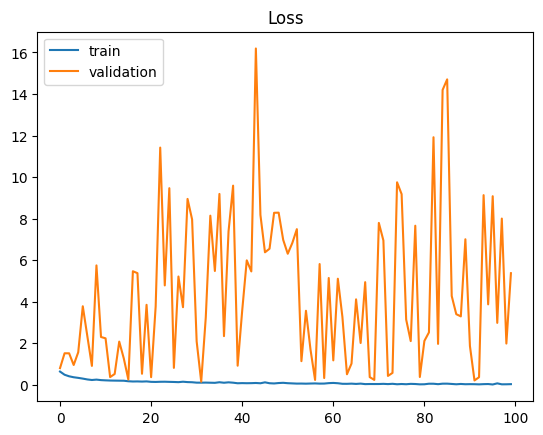

In [11]:
plt.plot(optim.history['loss'])
plt.plot(optim.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Loss')
plt.show()

In [12]:
np.array(optim.history['val_accuracy']).max()

0.9424460530281067

In [5]:
from tensorflow.keras.models import load_model

best_model = load_model('checkpoint.model41.keras')

In [6]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)

I0000 00:00:1733889236.834984   85776 service.cc:146] XLA service 0x7a67c80089e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733889236.835001   85776 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-12-10 20:53:56.840842: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 20:53:56.912696: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9390 - loss: 0.1564

I0000 00:00:1733889237.557198   85776 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9409 - loss: 0.1504


In [7]:
'Test loss:{0}, Test accuracy: {1}'.format(test_loss,test_acc)

'Test loss:0.1203400194644928, Test accuracy: 0.9510086178779602'

In [16]:
# Predict the values from the testing dataset
Y_pred_probs = best_model.predict(X_test)
Y_pred = np.array(Y_pred_probs>=.5)
# compute the confusion matrix
#confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred) 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Text(0, 0.5, 'freq')

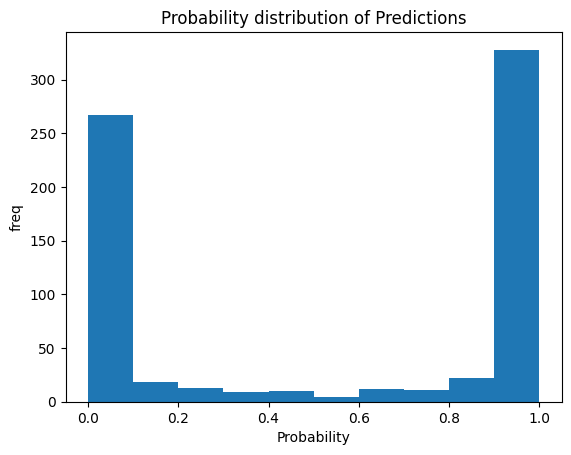

In [17]:
plt.hist(Y_pred_probs.flatten())
plt.title('Probability distribution of Predictions')
plt.xlabel('Probability')
plt.ylabel('freq')

Text(0, 0.5, 'freq')

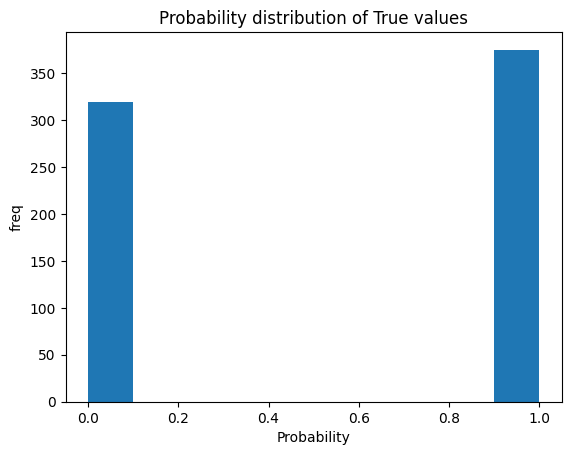

In [18]:
plt.hist(y_test)
plt.title('Probability distribution of True values')
plt.xlabel('Probability')
plt.ylabel('freq')

In [19]:
sum(y_test)

375.0

In [20]:
Y_pred = Y_pred.astype(float).flatten()

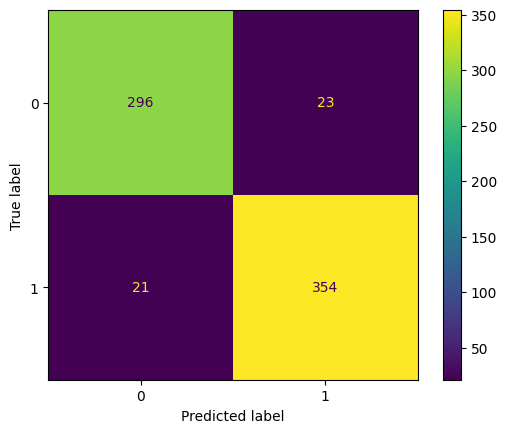

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, Y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [17]:
TP=152
TN=175
FP=13
FN=1

In [18]:
recall = TP/(TP+FN)
precision = TP/(TP+FP)

print(recall,precision)

0.9934640522875817 0.9212121212121213


In [19]:
(TP+TN)/(TP+TN+FP+FN)

0.9589442815249267

In [24]:
sk.metrics.precision_score(y_test, Y_pred)

0.9389920424403183

In [25]:
sk.metrics.recall_score(y_test, Y_pred)

0.944